In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("berkerisen/wind-turbine-scada-dataset")

print("Path to dataset files:", path)

print("Files in dataset directory:")
print(os.listdir(path))

100%|██████████| 1.50M/1.50M [00:00<00:00, 32.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/berkerisen/wind-turbine-scada-dataset/versions/3
Files in dataset directory:
['T1.csv']


In [3]:
csv_path = os.path.join(path, "T1.csv")

# Read it into a pandas DataFrame
df = pd.read_csv(csv_path)

# Display first few rows
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [4]:
# Drop invalid readings
df = df[(df['Wind Speed (m/s)'] >= 0) & (df['LV ActivePower (kW)'] >= 0)]

# Handle missing values
df = df.dropna()

# Optional: calculate power coefficient
df['Power_Coefficient'] = df['LV ActivePower (kW)'] / df['Theoretical_Power_Curve (KWh)']

# Encode categorical variables if any (wind direction might be binned)
df['Wind_Direction_Bin'] = pd.cut(df['Wind Direction (°)'], bins=8, labels=False)

# Normalize numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_cols = ['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


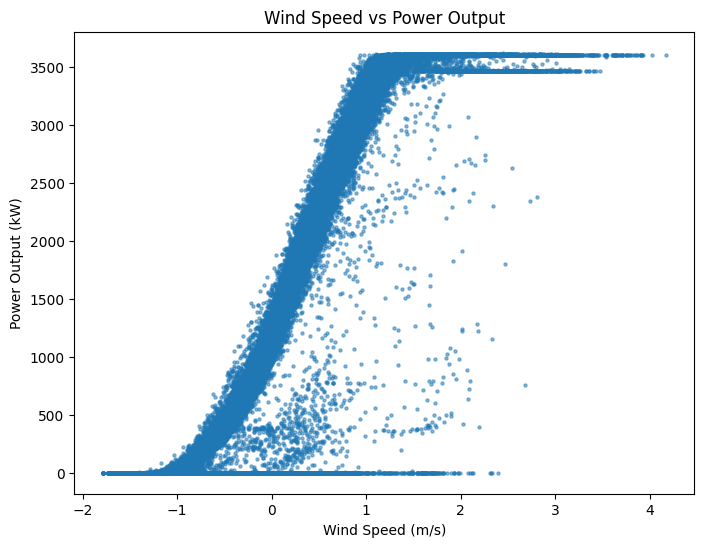

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(df['Wind Speed (m/s)'], df['LV ActivePower (kW)'], s=5, alpha=0.5)
plt.title("Wind Speed vs Power Output")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power Output (kW)")
plt.show()


In [6]:
from sklearn.model_selection import train_test_split

X = df[['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)']]
y = df['LV ActivePower (kW)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Training set: 35331 samples
Testing set: 15142 samples

Training models...

Training Linear Regression...
  R2 Score: 0.9086
  RMSE: 397.40 kW
  MAE: 184.88 kW

Training Gradient Boosting...
  R2 Score: 0.9190
  RMSE: 374.12 kW
  MAE: 154.62 kW

Training Neural Network...
  R2 Score: 0.9150
  RMSE: 383.11 kW
  MAE: 158.22 kW


Model Performance Comparison:
                         R2        RMSE         MAE
Linear Regression  0.908588  397.401913  184.880493
Gradient Boosting  0.918986  374.117374  154.622055
Neural Network     0.915046  383.106393  158.220599


Best performing model: Gradient Boosting
R2 Score: 0.9190



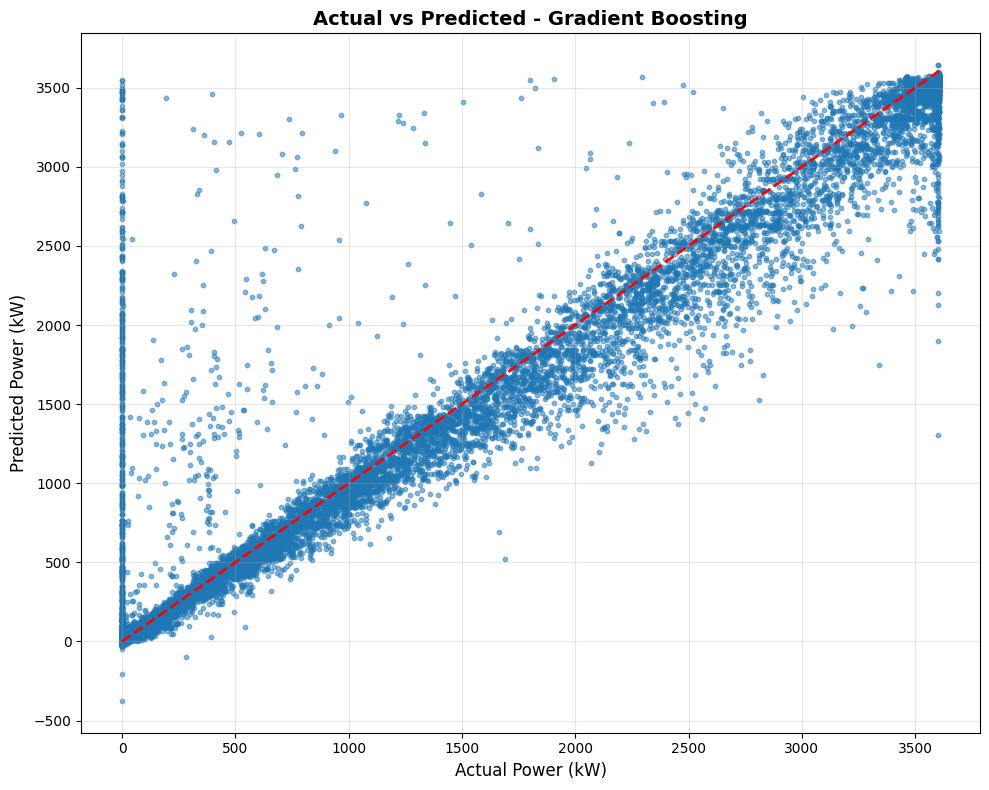

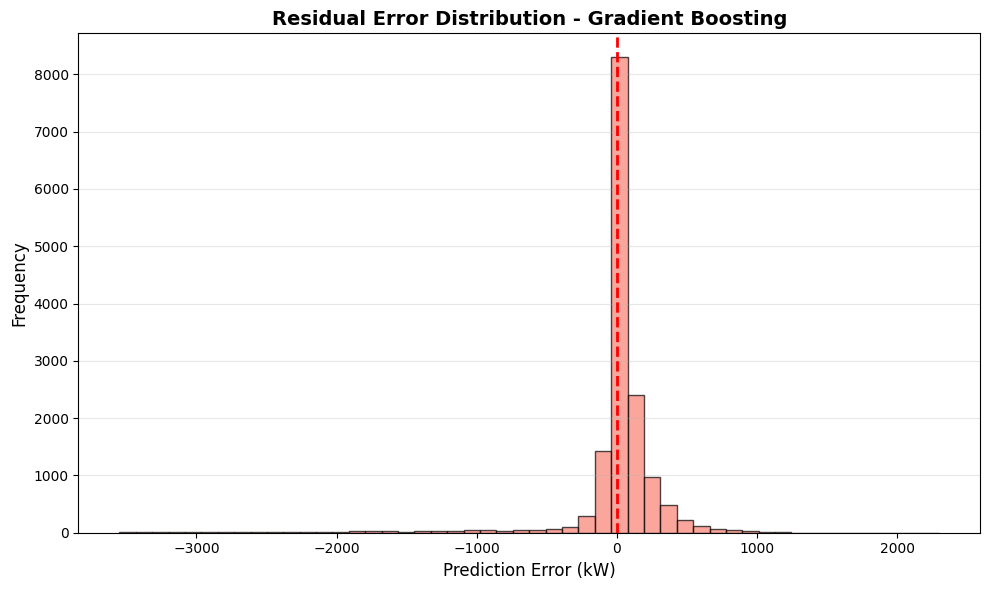

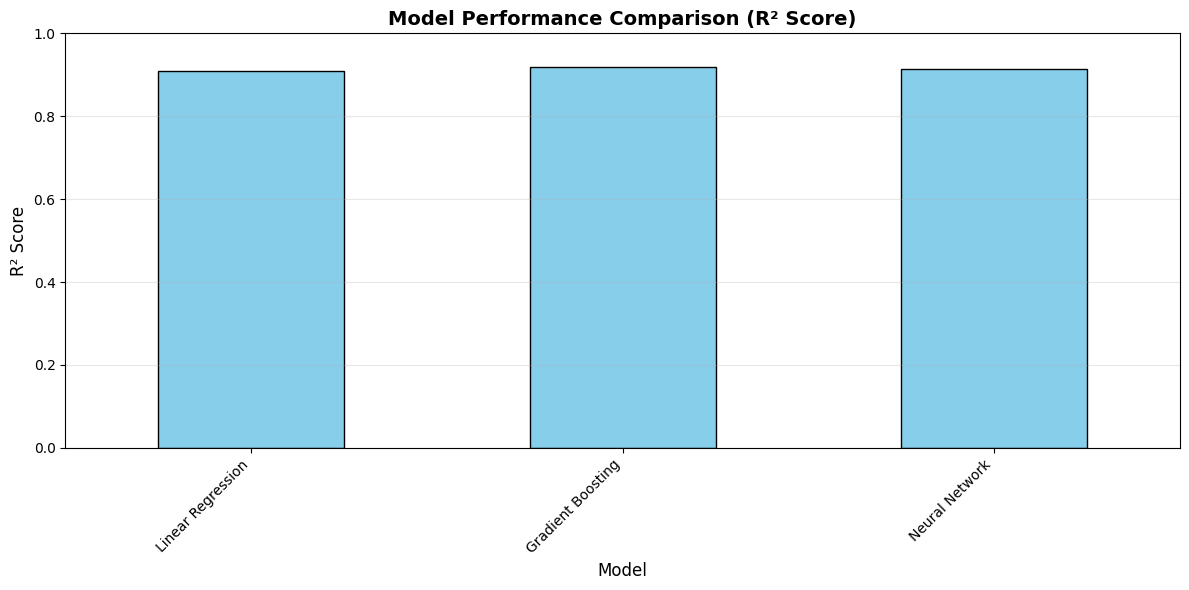

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Prepare features and target
X = df[['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)']]
y = df['LV ActivePower (kW)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples\n")

# Define models including Neural Network
models = {
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    "Neural Network": MLPRegressor(
        hidden_layer_sizes=(100, 50, 25),
        activation='relu',
        solver='adam',
        max_iter=500,
        learning_rate_init=0.001,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        verbose=False
    )
}

# Train and evaluate all models
results = {}

print("Training models...\n")

for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)

    results[name] = {
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae
    }

    print(f"  R2 Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.2f} kW")
    print(f"  MAE: {mae:.2f} kW\n")

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)
print("\n")

best_model_name = results_df['R2'].idxmax()
print(f"Best performing model: {best_model_name}")
print(f"R2 Score: {results_df.loc[best_model_name, 'R2']:.4f}\n")

# Visualizations
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

# Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test, preds, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Power (kW)", fontsize=12)
plt.ylabel("Predicted Power (kW)", fontsize=12)
plt.title(f"Actual vs Predicted - {best_model_name}", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residual Distribution
residuals = y_test - preds
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7, color='salmon')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title(f"Residual Error Distribution - {best_model_name}", fontsize=14, fontweight='bold')
plt.xlabel("Prediction Error (kW)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Model Comparison
plt.figure(figsize=(12, 6))
results_df['R2'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Model Performance Comparison (R² Score)", fontsize=14, fontweight='bold')
plt.xlabel("Model", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

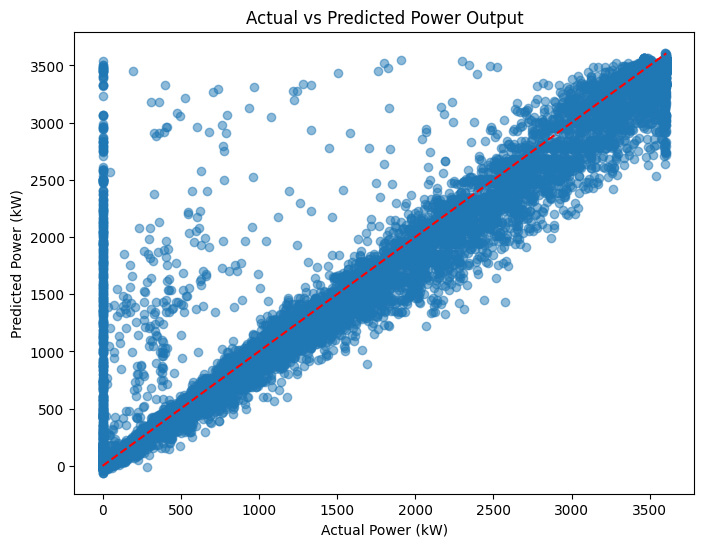

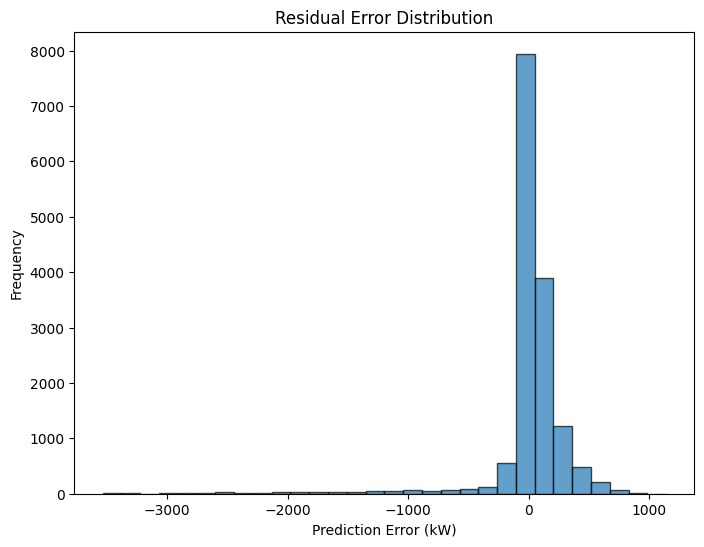

In [8]:
best_model = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)
preds = best_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Power (kW)")
plt.ylabel("Predicted Power (kW)")
plt.title("Actual vs Predicted Power Output")
plt.show()

plt.figure(figsize=(8,6))
plt.hist(y_test - preds, bins=30, edgecolor='k', alpha=0.7)
plt.title("Residual Error Distribution")
plt.xlabel("Prediction Error (kW)")
plt.ylabel("Frequency")
plt.show()
